In [1]:

import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
import numpy as np
from scipy.misc import imresize as imresize
import cv2
from PIL import Image
import warnings
warnings.filterwarnings("ignore")
features_blobs = []


def load_labels():
    # prepare all the labels
    # scene category relevant
    file_name_category = 'categories_places365.txt'
    if not os.access(file_name_category, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
        os.system('wget ' + synset_url)
    classes = list()
    with open(file_name_category) as class_file:
        for line in class_file:
            classes.append(line.strip().split(' ')[0][3:])
    classes = tuple(classes)

    # indoor and outdoor relevant
    file_name_IO = 'IO_places365.txt'
    if not os.access(file_name_IO, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/IO_places365.txt'
        os.system('wget ' + synset_url)
    with open(file_name_IO) as f:
        lines = f.readlines()
        labels_IO = []
        for line in lines:
            items = line.rstrip().split()
            labels_IO.append(int(items[-1]) -1) # 0 is indoor, 1 is outdoor
    labels_IO = np.array(labels_IO)

    # scene attribute relevant
    file_name_attribute = 'labels_sunattribute.txt'
    if not os.access(file_name_attribute, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/labels_sunattribute.txt'
        os.system('wget ' + synset_url)
    with open(file_name_attribute) as f:
        lines = f.readlines()
        labels_attribute = [item.rstrip() for item in lines]
    file_name_W = 'W_sceneattribute_wideresnet18.npy'
    if not os.access(file_name_W, os.W_OK):
        synset_url = 'http://places2.csail.mit.edu/models_places365/W_sceneattribute_wideresnet18.npy'
        os.system('wget ' + synset_url)
    W_attribute = np.load(file_name_W)

    return classes, labels_IO, labels_attribute, W_attribute

In [2]:

def hook_feature(module, input, output):
    features_blobs.append(np.squeeze(output.data.cpu().numpy()))

def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(imresize(cam_img, size_upsample))
    return output_cam

def returnTF():
# load the image transformer
    tf = trn.Compose([
        trn.Resize((224,224)),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return tf

In [3]:
def load_model():
    # this model has a last conv feature map as 14x14

    model_file = 'wideresnet18_places365.pth.tar'
    if not os.access(model_file, os.W_OK):
        os.system('wget http://places2.csail.mit.edu/models_places365/' + model_file)
        os.system('wget https://raw.githubusercontent.com/csailvision/places365/master/wideresnet.py')

    import wideresnet
    model = wideresnet.resnet18(num_classes=365)
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
    model.eval()
    model.eval()
    # hook the feature extractor
    features_names = ['layer4','avgpool'] # this is the last conv layer of the resnet
    for name in features_names:
        model._modules.get(name).register_forward_hook(hook_feature)
    return model

--TYPE OF ENVIRONMENT: indoor
--SCENE CATEGORIES:
0.108 -> ice_skating_rink/outdoor
0.100 -> department_store
0.090 -> airport_terminal
0.084 -> shopping_mall/indoor
0.056 -> arena/performance
--SCENE ATTRIBUTES:
no horizon, enclosed area, man-made, indoor lighting, glossy, congregating, socializing, spectating, competing
Original Image


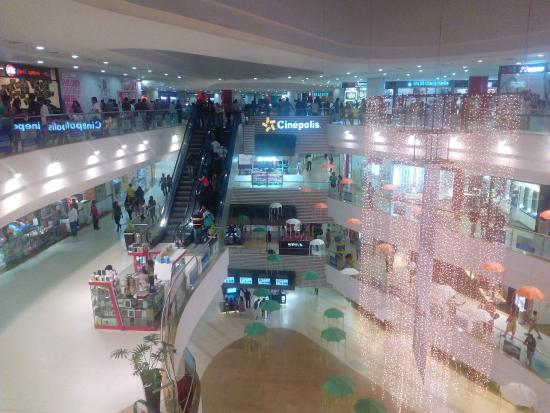

In [4]:
# load the labels
classes, labels_IO, labels_attribute, W_attribute = load_labels()

# load the model
features_blobs = []
model = load_model()

# load the transformer
tf = returnTF() # image transformer

# get the softmax weight
params = list(model.parameters())
weight_softmax = params[-2].data.numpy()
weight_softmax[weight_softmax<0] = 0

# load the test image
#img_url = 'http://places.csail.mit.edu/demo/6.jpg'
#os.system('wget %s -q -O test.jpg' % img_url)
img = Image.open('seasons_mall.jpg')
input_img = V(tf(img).unsqueeze(0))

# forward pass
logit = model.forward(input_img)
h_x = F.softmax(logit, 1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()


# output the IO prediction
io_image = np.mean(labels_IO[idx[:10]]) # vote for the indoor or outdoor
if io_image < 0.5:
    print('--TYPE OF ENVIRONMENT: indoor')
else:
    print('--TYPE OF ENVIRONMENT: outdoor')

# output the prediction of scene category
print('--SCENE CATEGORIES:')
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

# output the scene attributes
responses_attribute = W_attribute.dot(features_blobs[1])
idx_a = np.argsort(responses_attribute)
print('--SCENE ATTRIBUTES:')
print(', '.join([labels_attribute[idx_a[i]] for i in range(-1,-10,-1)]))

# generate class activation mapping
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])

# render the CAM and output
img = cv2.imread('seasons_mall.jpg')
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.4 + img * 0.5
cv2.imwrite('heatmap1.jpg', result)
from IPython.display import Image as I
print("Original Image")
I("seasons_mall.jpg")

Heatmap


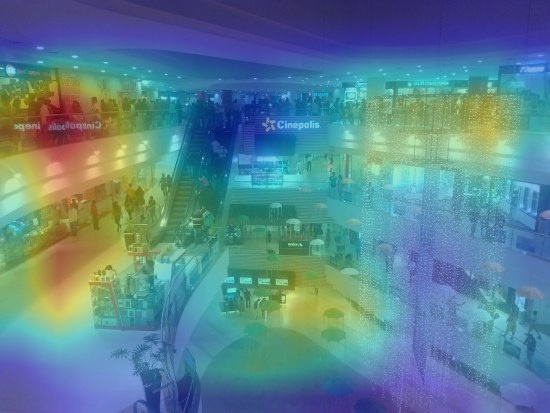

In [5]:
print("Heatmap")
I("heatmap1.jpg")